## Health Insurance Cross Sell Prediction

In [1]:
from IPython.core.display import Image,display
from IPython.core.display import HTML

In [2]:
Image(url="https://img.freepik.com/free-vector/vector-illustration-with-health-insurance-concept-big-clipboard-with-doctor-woman-healthcare_194782-1307.jpg")

#### Context

Our client is an Insurance company that has provided Health Insurance to its customers now they need your help in building a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company.

Building a model to predict whether a customer would be interested in Vehicle Insurance is extremely helpful for the company because it can then accordingly plan its communication strategy to reach out to those customers and optimise its business model and revenue.

Now, in order to predict, whether the customer would be interested in Vehicle insurance, you have information about demographics (gender, age, region code type), Vehicles (Vehicle Age, Damage), Policy (Premium, sourcing channel) etc.

More info: https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction 

#### Features

* `Id`: unique customer identifier.
* `Gender`: customer's gender.
* `Age`: customer's age.
* `Driving License`: 0, the client is not allowed to drive and 1, the client has to drive (CNH – National Driver's License)
* `Region Code`: Customer's region code.
* `Previously Insured`: 0, the customer does not have auto insurance and 1, the customer already has auto insurance.
* `Vehicle Age`: vehicle age.
* `Vehicle Damage`: 0, customer has never had his vehicle damaged in the past and 1, customer has had his vehicle damaged    in the past.
* `Annual Premium`: amount the customer paid the company for annual health insurance.
* `Policy sales channel`: anonymous code for the customer contact channel.
* `Vintage`: number of days the customer has been associated with the company through the purchase of health insurance.
* `Response`: 0, the customer is not interested and 1, the customer is interested.

#### Solution Approach

* <b>Ranked List</b>: The proposed solution will be the creation of a mailing list with customers most likely to purchase vehicle insurance. I'll be interested in looking at the cumulative gain curve to see if my classifier can deliver the best accuracy with the smallest possible sample. Thus, we will have as an output, a ranked list of the customers most likely (propensity score) to buy vehicle insurance. The smaller the sample size and the greater the cumulative gain, the greater the net gains for the company, as cold calling will be optimized with customers most likely to buy.

    Ranking Metrics infos: http://mlwiki.org/index.php/Cumulative_Gain_Chart
    
* <b>Deploy approach</b>: The rank algorithm will be incorporated in a googlesheets via GoogleScript API, being able to be activated by the user through a trigger/button containing the activation script. The expected result of the script's action will be the sorting of a mailing list, where the user most likely to purchase will be the first on the list, the second most likely to be the second and so on n times, where n is the number of customers on the list. .
    
* <b>CRISP-DM Workflow</b>: This analytical process follows the CRISP-DM methodology, which considers a cyclical approach to problem solving. Therefore, the analytical process goes through all the phases of a data mining life cycle, focusing on the reduction of wasted resources, delivering value in a short period of time. In some cases it may take more than one cycle if adjustments are necessary (to improve metrics). 

    CRISP-DM infos: https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining

# 0.0. Imports

In [3]:
# Database and Operations
import pandas as pd
import numpy as np
import math
import random
import psycopg2
import json

# Machine Learning
from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn import linear_model as lm

# Visual
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt

# Others
import datetime 
import warnings
import pickle 
import requests
from flask import Flask, request, Response


warnings.filterwarnings('ignore')

## 0.1. Helper Functions

In [4]:
# Auxiliary functions for better workflow
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>' ) )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [17]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Dataset

In [4]:
# Pull data from AWS DB
# Credentials

# Host
h = "comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com"

# Port
p = 5432

# DataBase
db = "comunidadedsdb"

# User
u = "member"

# Password
pw = "cdspa"

# Connection

conn = psycopg2.connect(host=h, port=p, database=db, user=u, password=pw)

In [5]:
# List of schemas
df1 = pd.read_sql("SELECT nspname FROM pg_catalog.pg_namespace;",conn)
df1

,nspname
0,pg_toast
1,pg_temp_1
2,pg_toast_temp_1
3,pg_catalog
4,information_schema
5,public
6,pa004
7,pg_temp_4
8,pg_toast_temp_4
9,pa005


In [6]:
# I'm only interested in schema pa004 tables
df1 = pd.read_sql("SELECT tablename FROM pg_tables WHERE schemaname='pa004';",conn)
df1

,tablename
0,users
1,vehicle
2,insurance


In [7]:
# Checking users table 
users = pd.read_sql("SELECT * FROM pa004.users LIMIT 10;",conn)
users

,id,gender,age,region_code,policy_sales_channel
0,1,Male,44,28.0,26.0
1,2,Male,76,3.0,26.0
2,3,Male,47,28.0,26.0
3,4,Male,21,11.0,152.0
4,5,Female,29,41.0,152.0
5,6,Female,24,33.0,160.0
6,7,Male,23,11.0,152.0
7,8,Female,56,28.0,26.0
8,9,Female,24,3.0,152.0
9,10,Female,32,6.0,152.0


In [8]:
# Checking vehicle table
vehicle = pd.read_sql("SELECT * FROM pa004.vehicle LIMIT 10;",conn)
vehicle

,id,driving_license,vehicle_age,vehicle_damage
0,1,1,> 2 Years,Yes
1,2,1,1-2 Year,No
2,3,1,> 2 Years,Yes
3,4,1,< 1 Year,No
4,5,1,< 1 Year,No
5,6,1,< 1 Year,Yes
6,7,1,< 1 Year,Yes
7,8,1,1-2 Year,Yes
8,9,1,< 1 Year,No
9,10,1,< 1 Year,No


In [9]:
# Checking insurance table
insurance = pd.read_sql("SELECT * FROM pa004.insurance LIMIT 10;",conn)
insurance

,id,previously_insured,annual_premium,vintage,response
0,1,0,40454.0,217,1
1,2,0,33536.0,183,0
2,3,0,38294.0,27,1
3,4,1,28619.0,203,0
4,5,1,27496.0,39,0
5,6,0,2630.0,176,0
6,7,0,23367.0,249,0
7,8,0,32031.0,72,1
8,9,1,27619.0,28,0
9,10,1,28771.0,80,0


* The tables share the same id
* We can do a left join on id and save all data in a single table

In [10]:
# left join on id
query_tables = """
    SELECT * 
    FROM pa004.users u LEFT JOIN pa004.vehicle v ON (u.id = v.id)
                       LEFT JOIN pa004.insurance i ON (u.id = i.id)
"""
raw = pd.read_sql(query_tables, conn)
raw.head()

,id,gender,age,region_code,policy_sales_channel,id,driving_license,vehicle_age,vehicle_damage,id,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,7,1,< 1 Year,Yes,7,0,23367.0,249,0
1,13,Female,41,15.0,14.0,13,1,1-2 Year,No,13,1,31409.0,221,0
2,18,Female,25,35.0,152.0,18,1,< 1 Year,No,18,1,46622.0,299,0
3,31,Female,26,8.0,160.0,31,1,< 1 Year,No,31,0,2630.0,136,0
4,39,Male,45,8.0,124.0,39,1,1-2 Year,Yes,39,0,42297.0,264,0


In [11]:
# Rename columns 5 and 9 to be the only ones id's deleted in drop
new_columns = ['id', 'gender', 'age', 'region_code', 'policy_sales_channel', 'id_2',
               'driving_license', 'vehicle_age', 'vehicle_damage', 'id_3',
               'previously_insured', 'annual_premium', 'vintage', 'response']

raw.columns = new_columns

# Drop excess ids
raw = raw.drop(columns=raw.columns[[5,9]], axis=1)
raw.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,1,< 1 Year,Yes,0,23367.0,249,0
1,13,Female,41,15.0,14.0,1,1-2 Year,No,1,31409.0,221,0
2,18,Female,25,35.0,152.0,1,< 1 Year,No,1,46622.0,299,0
3,31,Female,26,8.0,160.0,1,< 1 Year,No,0,2630.0,136,0
4,39,Male,45,8.0,124.0,1,1-2 Year,Yes,0,42297.0,264,0


# 1.0. Data Description

In [12]:
# Checkpoint
df1 = raw.copy()

## 1.1. Data Dimension

In [13]:
# Number of rows and columns
print('number of rows: {r} , number of cols: {c}'.format(r=df1.shape[0], c=df1.shape[1]))

number of rows: 381109 , number of cols: 12


## 1.2. Data Types

In [14]:
# Change columns names
new_cols = [x.lower() for x in df1.columns]
new_cols

['id',
 'gender',
 'age',
 'region_code',
 'policy_sales_channel',
 'driving_license',
 'vehicle_age',
 'vehicle_damage',
 'previously_insured',
 'annual_premium',
 'vintage',
 'response']

In [15]:
# Data types
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

* no change of type will be required so far

## 1.3. Check NA

In [16]:
# Checking NA's
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

* there is no empty data

## 1.4. Data Descriptive

In [17]:
# let's separate the data between numeric and categorical
num_vars = df1.select_dtypes(include=['int64','float64'])
cat_vars = df1.select_dtypes(exclude=['int64','float64', 'datetime64[ns]'])

In [18]:
# num_vars quick view
num_vars.head()

,id,age,region_code,policy_sales_channel,driving_license,previously_insured,annual_premium,vintage,response
0,7,23,11.0,152.0,1,0,23367.0,249,0
1,13,41,15.0,14.0,1,1,31409.0,221,0
2,18,25,35.0,152.0,1,1,46622.0,299,0
3,31,26,8.0,160.0,1,0,2630.0,136,0
4,39,45,8.0,124.0,1,0,42297.0,264,0


In [19]:
# cat_vars quick view
cat_vars.head()

,gender,vehicle_age,vehicle_damage
0,Male,< 1 Year,Yes
1,Female,1-2 Year,No
2,Female,< 1 Year,No
3,Female,< 1 Year,No
4,Male,1-2 Year,Yes


In [20]:
# Unique classes
cat_vars.apply(lambda x: x.unique().shape[0])

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

In [21]:
# Central Tendency
mean = pd.DataFrame(num_vars.apply(np.mean)).T
med = pd.DataFrame(num_vars.apply(np.median)).T

# Dispersion
mn = pd.DataFrame(num_vars.apply(np.min)).T
mx = pd.DataFrame(num_vars.apply(np.max)).T
std = pd.DataFrame(num_vars.apply(np.std)).T
rng = pd.DataFrame(num_vars.apply(lambda x: x.max() - x.min())).T
skw = pd.DataFrame(num_vars.apply(lambda x: x.skew())).T 
krt = pd.DataFrame(num_vars.apply(lambda x: x.kurtosis())).T 
                   
# Concatenate all in a single DataFrame
n = pd.concat([mean, med, mn, mx, std, rng, skw, krt]).T.reset_index()
n.columns = ['descriptive', 'mean', 'median', 'min', 'max', 'std', 'range', 'skew', 'kurtosis']
n

,descriptive,mean,median,min,max,std,range,skew,kurtosis
0,id,190555.000000,190555.0,1.0,381109.0,110016.691870,381108.0,-8.071174e-18,-1.200000
1,age,38.822584,36.0,20.0,85.0,15.511591,65.0,6.725390e-01,-0.565655
2,region_code,26.388807,28.0,0.0,52.0,13.229871,52.0,-1.152664e-01,-0.867857
3,policy_sales_channel,112.034295,133.0,1.0,163.0,54.203924,162.0,-9.000081e-01,-0.970810
4,driving_license,0.997869,1.0,0.0,1.0,0.046109,1.0,-2.159518e+01,464.354302
5,previously_insured,0.458210,0.0,0.0,1.0,0.498251,1.0,1.677471e-01,-1.971871
6,annual_premium,30564.389581,31669.0,2630.0,540165.0,17213.132474,537535.0,1.766087e+00,34.004569
7,vintage,154.347397,154.0,10.0,299.0,83.671194,289.0,3.029517e-03,-1.200688
8,response,0.122563,0.0,0.0,1.0,0.327935,1.0,2.301906e+00,3.298788


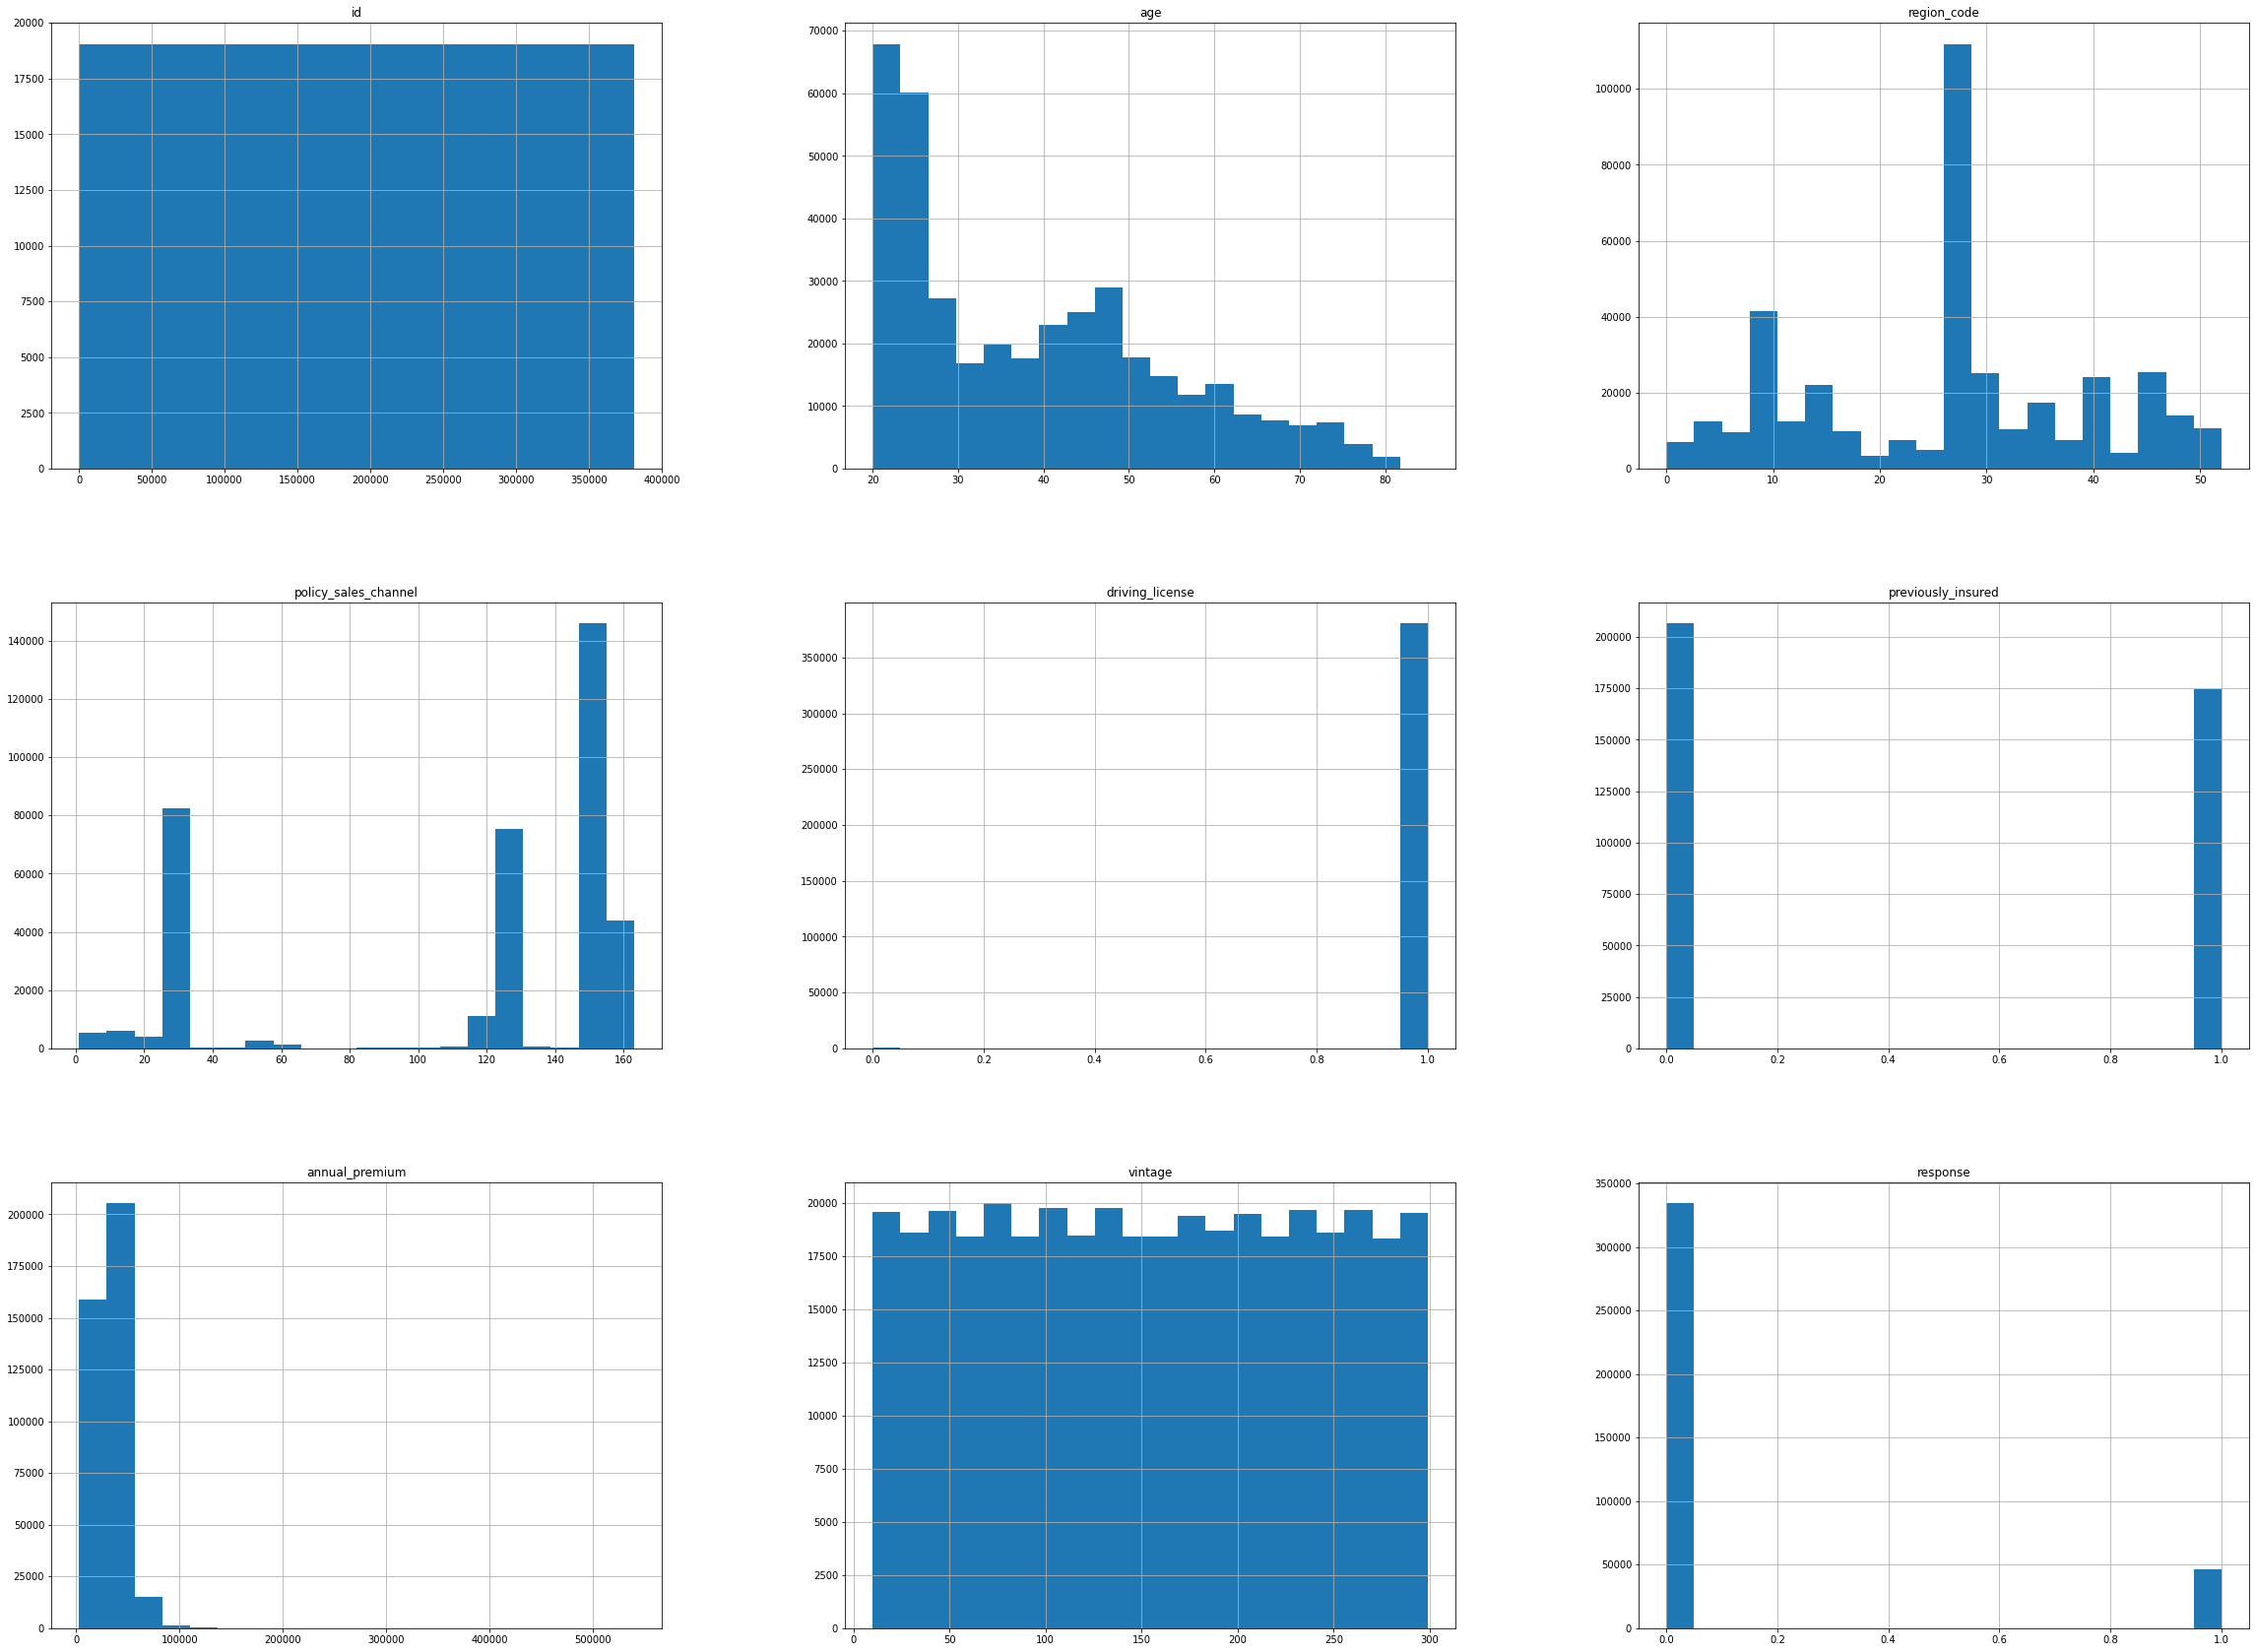

In [22]:
num_vars.hist(bins=20, figsize=(40,30));

### Important points:
1. `annual_premium` with a maximum of 540.165 rupees seems curious, given that an average health insurance in india costs around 15.200 rupees per year (https://www.movehub.com/us/international-moving/india/healthcare-for-expats/). That could be a luxury plan or something. For now, we will stick with any value assuming they are not outliers, since we don't have more information in the dataset.

2. `policy_sales_channel` is also curious. 163 different channels is quite a lot given that they are customer advertising channels. But, once again, we don't have more information in the dataset to make any conclusions.

3. There are approximately 300,000 examples of `response` == 0 (not interested) versus approximately 50,000 examples of `response` == 1 (interested). We'll take a closer look at this variable (as is) in the next few steps, to extract some business insights and to understand the nature of imbalance.

I will focus on running the first stage of CRISP-DM assuming these limitations and seeing how the algorithms perform. In the real world, asking the business team for more information about features can be interesting.

### Frequency Table

In [23]:
gender = cat_vars['gender'].value_counts(normalize=True).apply(lambda x: str(round(x*100))+'%').reset_index()
vehicle_age = cat_vars['vehicle_age'].value_counts(normalize=True).apply(lambda x: str(round(x*100))+'%').reset_index()
vehicle_damage = cat_vars['vehicle_damage'].value_counts(normalize=True).apply(lambda x: str(round(x*100))+'%').reset_index()

In [24]:
n = pd.concat([gender, vehicle_age, vehicle_damage])
n.fillna(value='-').rename(columns={'index':'Categories'}).T

,0,1,0,1,2,0,1
Categories,Male,Female,1-2 Year,< 1 Year,> 2 Years,Yes,No
gender,54%,46%,-,-,-,-,-
vehicle_age,-,-,53%,43%,4%,-,-
vehicle_damage,-,-,-,-,-,50%,50%


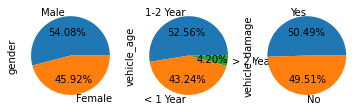

In [25]:
plt.subplot(1,3,1)
cat_vars['gender'].value_counts().plot.pie(rot=0, autopct='%.2f%%')

plt.subplot(1,3,2)
cat_vars['vehicle_age'].value_counts().plot.pie(rot=0, autopct='%.2f%%')

plt.subplot(1,3,3)
cat_vars['vehicle_damage'].value_counts().plot.pie(rot=0, autopct='%.2f%%');

# 2.0. Feature Engineering

In [26]:
# Checkpoint
df2 = df1.copy()

In [27]:
# Quick view
df2.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,1,< 1 Year,Yes,0,23367.0,249,0
1,13,Female,41,15.0,14.0,1,1-2 Year,No,1,31409.0,221,0
2,18,Female,25,35.0,152.0,1,< 1 Year,No,1,46622.0,299,0
3,31,Female,26,8.0,160.0,1,< 1 Year,No,0,2630.0,136,0
4,39,Male,45,8.0,124.0,1,1-2 Year,Yes,0,42297.0,264,0


In [28]:
# I'll rename some categories for better organization
# Change vehicle_age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_years' 
                                                                       if x == '1-2 Year' else 'below_1_year')
# Change vehicle_damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# 3.0. Data Filtering

In [29]:
df3 = df2.copy()

# 4.0. EDA

This analysis is important to understand how the predictors relate to each other and to the target variable, generating business insights and revealing features relevant to our model. In addition, below, we will use a model for feature selection to contrast our findings, improving our choice of relevant variables for the final model.

In [30]:
df4 = df3.copy()

## 4.1. Bivariate Analysis

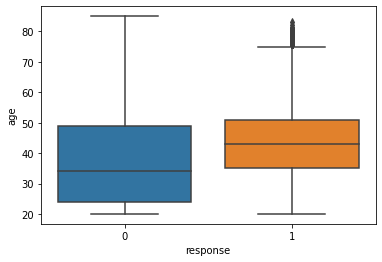

In [31]:
# Age
sns.boxplot(x='response', y='age', data=df4);

We have different age ranges for people who are interested in the product compared to those who are not.
But let's check this more closely, with the help of distributions.

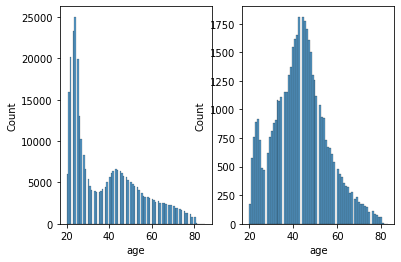

In [32]:
# Checking distributions
plt.subplot(1,2,1)
aux1 = df4[df4['response'] == 0]['age']
sns.histplot(aux1);

plt.subplot(1,2,2)
aux2 = df4[df4['response'] == 1]['age']
sns.histplot(aux2);

`age` seems to be a representative feature that separates classes relatively well, but we may have problems with the volume of examples between ages.

Note the peaks between 20-30 years in non-interested and the peaks between 40-50 years in interested.
The data has a lot more examples in the peaks of not interested people than interested people (approx. 25,000 vs approx. 1,750)

It's something to keep in mind and we'll take care of that later.

In [33]:
# gender
aux = pd.crosstab(index=df4['gender'], columns=df4['response'], normalize='index').apply(lambda x: round(x*100,2), axis=1)
aux

response,0,1
gender,,
Female,89.61,10.39
Male,86.16,13.84


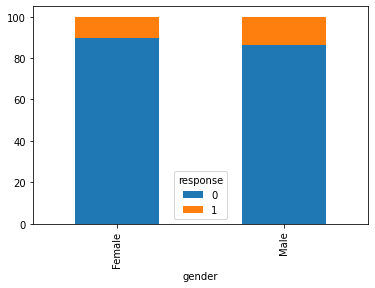

In [34]:
aux.plot.bar(stacked=True);

There is approximately a 3% difference in the amount of `response` between genders. `gender` is a non-discriminatory variable and therefore apparently not relevant to the model. Let's move on.

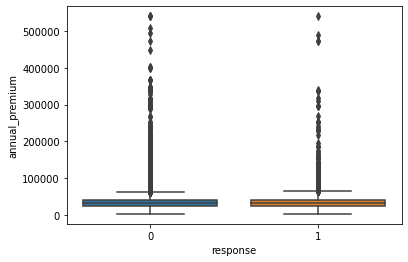

In [35]:
# annual_premium
sns.boxplot(x='response', y='annual_premium', data=df4);

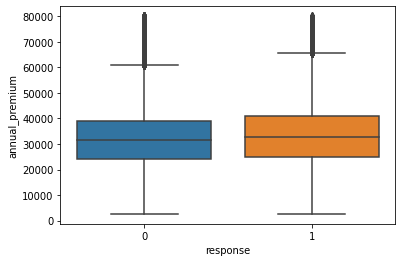

In [36]:
# Let's filter outliers in annual_premium a little bit for a better visualization
aux = df4[df4['annual_premium'] < 80000]
sns.boxplot(x='response', y='annual_premium', data=aux);

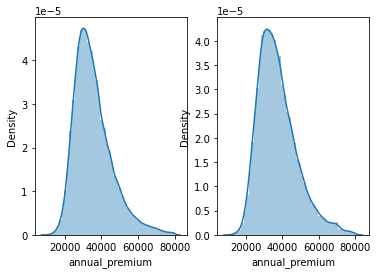

In [37]:
# Checking distributions
# Filtering the annual_premium peak that occurs below 10000 
aux0 = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]

plt.subplot(1,2,1)
aux1 = aux0[aux0['response'] == 0]['annual_premium']
sns.distplot(aux1);

plt.subplot(1,2,2)
aux2 = aux0[aux0['response'] == 1]['annual_premium']
sns.distplot(aux2);


If we were to distinguish the median of `annual_premium` for customers who are interested in vehicle insurance (`response` == 1) compared to customers who are not interested (`response` == 0), we would not see any difference in the medians, demonstrating that `annual_premium` doesn't segregate classes so well.

Maybe combining `annual_premium` with another variable bring a better segregation, but for now the feature does not seem to be a contributor to future models. 

In [38]:
# driving_license 
aux = pd.crosstab(index=df4['driving_license'], columns=df4['response'], normalize='index')
aux.apply(lambda x: x*100)

response,0,1
driving_license,,
0,94.950739,5.049261
1,87.728276,12.271724


Of the people who have a driver's license, only 12.27% are interested in car insurance.

It is a variable that seems discriminatory, but needs to be analyzed in combination with other variables.

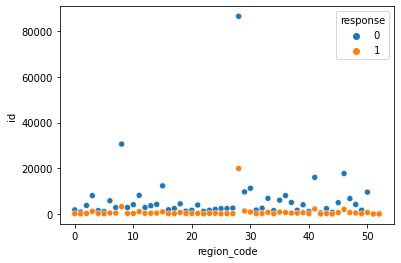

In [39]:
# region_code
aux = df4[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()

sns.scatterplot(x='region_code',y='id',hue='response',data=aux);

`region_code` looks a bit homogenous. For now, it doesn't seem to be a class with great discriminatory power.

In [40]:
# previously_insured
aux = pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: round((x / x.sum())*100, 2), axis=1)
aux

response,0,1
previously_insured,,
0,77.45,22.55
1,99.91,0.09


The frequency table shows us delicate information: Almost 100% of `previously_insured` do not want to buy car insurance. Technically this situation can be interpreted as a data leakage. Let's keep this in mind and check further later.

In [41]:
# vehicle_age
aux = df4[['vehicle_age', 'response']].value_counts(normalize=True).apply(lambda x: round(x*100,2)).reset_index()
aux.sort_values('vehicle_age',ascending=True)

,vehicle_age,response,0
1,below_1_year,0,41.35
4,below_1_year,1,1.89
0,between_1_2_years,0,43.43
2,between_1_2_years,1,9.13
3,over_2_years,0,2.97
5,over_2_years,1,1.23


In `vehicle_age`, there is a great potential for class discrimination between people with vehicles that are up to 2 years old, decreasing among people with vehicles that has over 2 years. Thus, the variable may or may not be useful to our model.

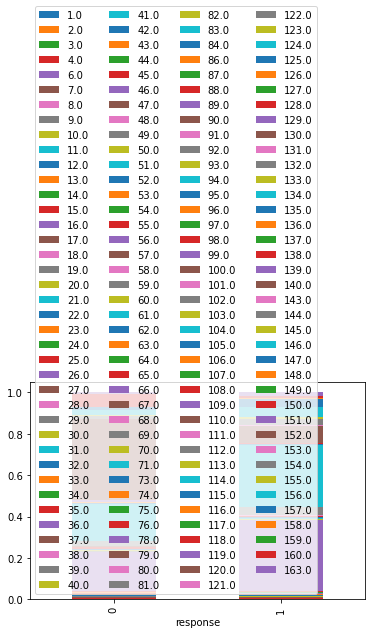

In [42]:
# policy_sales_channel
aux = pd.crosstab(index=df4['response'],columns=df4['policy_sales_channel'], normalize='index')

#checking how channel is divided by response 
aux1 = aux.plot.bar(stacked=True).legend(ncol=4);

`policy sales channel` seems to segregate `response` in an interesting way. Note the proportions of each color (channel) for `response` == 0 and `response` == 1

In [43]:
# Top 5 differences in response between channels
aux1 = aux.T.apply(lambda x: x[1] - x[0], axis=1)
aux1.sort_values(ascending=False).apply(lambda x: x*100).reset_index().head(5)

,policy_sales_channel,0
0,26.0,14.938857
1,124.0,12.021267
2,156.0,2.416373
3,157.0,2.378394
4,154.0,1.804262


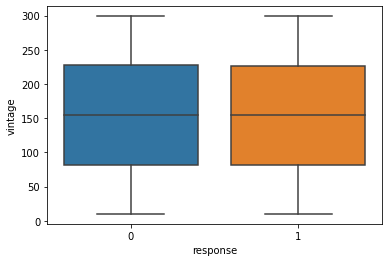

In [44]:
# vintage
sns.boxplot(x='response', y='vintage', data=df4);

`vintage` looks pretty homogeneous. Let's look at the distributions.

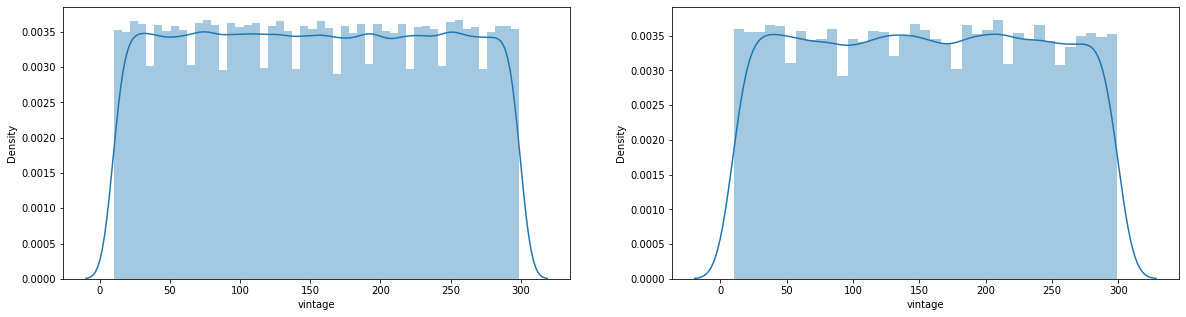

In [45]:
aux1 = df4[df4['response'] == 0]['vintage']
aux2 =  df4[df4['response'] == 1]['vintage']

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.distplot(aux1);

plt.subplot(1,2,2)
sns.distplot(aux2);

`vintage` does not appear to be a discriminatory variable for `response` because both the medians and the distributions are quite similar.

# 5.0. Data Preparation

In this step we will focus on transforming the variables in congruence with their statistical nature, so that our machine leraning model has an adequate performance.

In [46]:
# Checkpoint
df5 = df4.copy()

In [47]:
# Split data into training and validation
x = df4.drop('response', axis=1)
y = df4['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(x, y, test_size=0.20)
df5 = pd.concat([x_train, y_train], axis=1)

## 5.1. Standardization

In [48]:
# Class instantiation for standardization
ss = pp.StandardScaler()

In [49]:
# annual_premium
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)

# save to binary
pickle.dump(ss, open(r'C:\Users\psvin\Documents\repos\portfolio-DS\health_insurance\src\features\annual_premium_scaler.pkl', 'wb'))

Although we don't know the context of the outliers for annual premium`annual_premium` , i'll assume that the high values in `annual_premium` are useless outliers and treat the variable with standardization given its shape without the outliers. I'll do this way for convenience, taking the risk, to save time.

If an adjustment is needed, we will do so in the second round of CRISP-DM.

## 5.2. Rescaling

In [50]:
# age
mms_age = pp.MinMaxScaler()
df5['age'] = mms_age.fit_transform(df5[['age']].values)

# vintage
mms_vintage = pp.MinMaxScaler()
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)

# save to binary
pickle.dump(mms_age, open(r'C:\Users\psvin\Documents\repos\portfolio-DS\health_insurance\src\features\age_scaler.pkl', 'wb'))
pickle.dump(mms_vintage, open(r'C:\Users\psvin\Documents\repos\portfolio-DS\health_insurance\src\features\vintage_scaler.pkl', 'wb'))

## 5.3. Encoder

In [51]:
# gender
te_gender = df5.groupby('gender')['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map(te_gender)

# region_code - Target Encoding
te_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map(te_region_code)

# vehicle_age - One Hot Encoding 
df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_channel - Frequency Encoding  
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)

# save to binary
pickle.dump(te_gender, open(r'C:\Users\psvin\Documents\repos\portfolio-DS\health_insurance\src\features\te_gender_scaler.pkl', 'wb'))
pickle.dump(te_region_code, open(r'C:\Users\psvin\Documents\repos\portfolio-DS\health_insurance\src\features\te_region_code_scaler.pkl', 'wb'))
pickle.dump(fe_policy_sales_channel, open(r'C:\Users\psvin\Documents\repos\portfolio-DS\health_insurance\src\features\fe_policy_sales_channel_scaler.pkl', 'wb'))

In [52]:
# checking data 
df5.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,previously_insured,annual_premium,vintage,response,vehicle_age_below_1_year,vehicle_age_between_1_2_years,vehicle_age_over_2_years
153329,82460,0.137274,0.538462,0.067967,0.353583,1,0,1,-1.620012,0.086505,0,0,1,0
306512,162795,0.137274,0.323077,0.185989,0.194406,1,1,0,0.340798,0.906574,0,0,0,1
227727,294195,0.137274,0.353846,0.078202,0.194406,1,1,0,1.241747,0.439446,0,0,1,0
288790,20812,0.103905,0.046154,0.185989,0.353583,1,1,0,-0.006653,0.844291,0,1,0,0
338946,43087,0.137274,0.046154,0.097178,0.353583,1,0,1,-1.620012,0.847751,0,1,0,0


## 5.4. Validation Preparation

In [53]:
# gender
x_validation.loc[:, 'gender'] = x_validation.loc[:, 'gender'].map(te_gender)

# age
x_validation.loc[:, 'age'] = mms_age.fit_transform(x_validation[['age']].values)

# region_code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map(te_region_code)

# vehicle_age
x_validation = pd.get_dummies(x_validation, prefix='vehicle_age', columns=['vehicle_age'])

# annual_premium
x_validation.loc[:, 'annual_premium'] = ss.fit_transform(x_validation[['annual_premium']].values)

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map(fe_policy_sales_channel)

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.fit_transform(x_validation[['vintage']].values)

# fillna
x_validation = x_validation.fillna(0) # check this later

# 6.0. Feature Selection

## 6.1. Features Importance

In this step, I will apply an Extra Trees method for feature selection. Extra trees have good processing speed and low bias, being an interesting algorithm in the selection of features in this first stage of CRISP, where we want to quickly generate value for the business team.

In [54]:
# Model definition
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=1)

# Data preparation
x_train_n = df5.drop(['id', 'response'], axis=1)
y_train_n = y_train.values

# Model fit
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=1, random_state=0)

Feature Ranking:
                         feature  importance
0                        vintage    0.272441
0                 annual_premium    0.244098
0                            age    0.166662
0                    region_code    0.105348
0                 vehicle_damage    0.066403
0           policy_sales_channel    0.059223
0             previously_insured    0.057404
0       vehicle_age_below_1_year    0.014684
0  vehicle_age_between_1_2_years    0.006399
0                         gender    0.004752
0       vehicle_age_over_2_years    0.002103
0                driving_license    0.000484


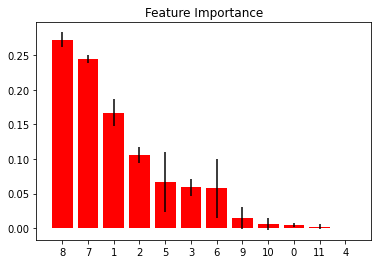

In [55]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print('Feature Ranking:')
df = pd.DataFrame()
for i,j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)
    
print(df.sort_values('importance', ascending=False))
      
# Plot the impurity-based feature importance of the forest

plt.figure()
plt.title('Feature Importance') 
plt.bar(range(x_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()


I'm going to choose an arbitrary 5% cutoff rate for the importance of variables. Let's see how the model performs and if necessary, we will make adjustments to this rate in another round.

# 7.0. Machine Learning Model

In this step, I'm interested in finding the optimal ordering of interested clients. For this, we must find the model that best reaches interested customers, with the smallest sample of customers ordered by propensity to buy.

In [56]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured', 'policy_sales_channel']

x_train = df5[cols_selected]
x_val = x_validation[cols_selected]
y_val = y_validation.copy()

## 7.1. KNN

In [57]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=2)

# model training
knn_model.fit(x_train, y_train)

# model_prediction
yhat_knn = knn_model.predict_proba(x_val)

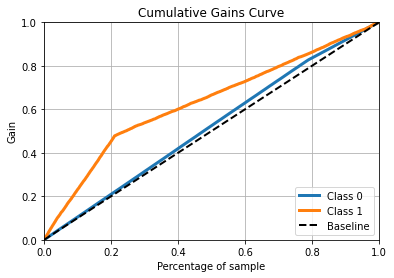

In [58]:
# Cumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn);

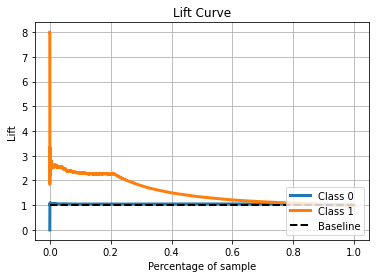

In [59]:
# Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_knn);

## 7.2. Logistic Regression

In [60]:
# model definition
lr_model = lm.LogisticRegression(random_state=42)

# model training
lr_model.fit(x_train, y_train)

# model_prediction
yhat_lr = lr_model.predict_proba(x_val)

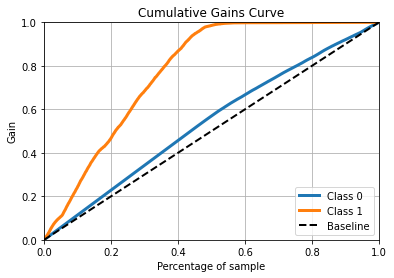

In [61]:
# Cumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr);

Compared to `KNN`, `Logistic Regression` achieves almost 100% of interested customers, reaching approximately 50% of the ordered customer database (`KNN` needs 100% of sample).

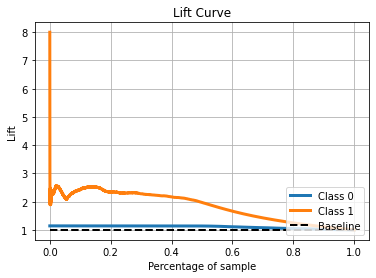

In [62]:
# Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_lr);

## 7.3. Extra Trees

In [63]:
# model definition
et = en.ExtraTreesClassifier(n_estimators=1000, random_state=0, n_jobs=1)

# model training
et.fit(x_train, y_train)

# model prediction
yhat_et =  et.predict_proba(x_val)

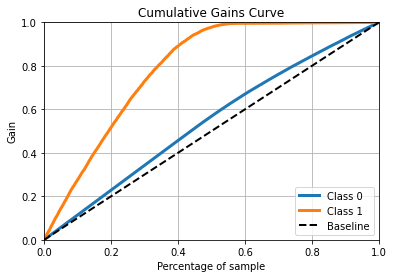

In [64]:
# Cumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_et);

`Extra Trees` appears to have a marginal difference compared to `Logistic Regression` in terms of cumulative gains.

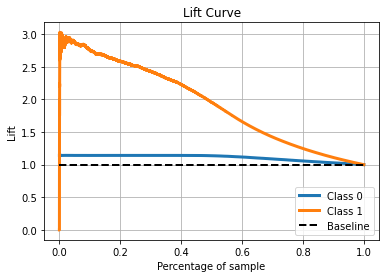

In [65]:
# Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_et);

## 7.4. Random Forest

In [66]:
# model definition
rf = en.RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)

# model training
rf.fit(x_train, y_train)

# model_prediction
yhat_rf = rf.predict_proba(x_val)

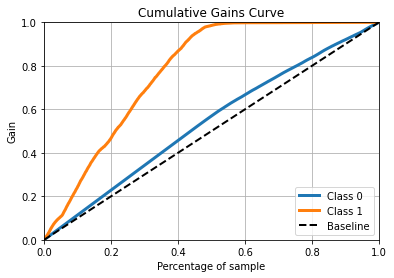

In [67]:
# Cumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr);

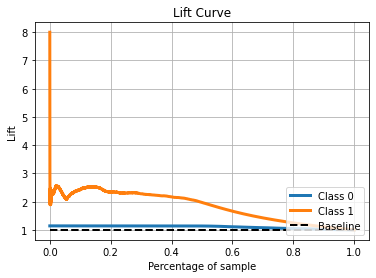

In [68]:
# Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_lr);

# 8.0. Model Performance

In [69]:
# precision at kth customer 
def precision_at_k(data, k=2000):
    # reset index
    data = data.reset_index(drop=True)

    # create ranking order
    # add 1 to start from the first at k
    data['ranking'] = data.index + 1

    # precision at k
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return data.loc[k, 'precision_at_k']

In [70]:
# recall at kth customer 
def recall_at_k(data, k=2000):
    # reset index
    data = data.reset_index(drop=True)

    # create ranking order
    # add 1 to start from the first at k
    data['ranking'] = data.index + 1

    # precision at k
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return data.loc[k, 'recall_at_k']

In [71]:
# copy data
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

In [72]:
# propensity score
df8['score'] = yhat_knn[:, 1].tolist()

# sort clients by propensity score
df8 = df8.sort_values('score', ascending=False)

# compute precision at k
precision_at_50 = precision_at_k(df8, k=50)

# compute recall at k
recall_at_50 = recall_at_k(df8, k=50)

In [73]:
print('Precision at k: {p}\nRecall at k: {r}'.format(p = precision_at_50, r=recall_at_50))

Precision at k: 0.27450980392156865
Recall at k: 0.0014690451206715634


# 9.0. Deploy To Production

## 9.1. Health Insurance Class

In [74]:
# Save trained model
pickle.dump(lr_model, open(r'C:\Users\psvin\Documents\repos\portfolio-DS\health_insurance\src\models\lr_model.pkl', 'wb'))

In [75]:
# Create class and objects
class HealthInsurance:
    
    def __init__( self ):
        self.home_path = r'C:\Users\psvin\Documents\repos\portfolio-DS\health_insurance'
        self.annual_premium_scaler =            pickle.load(open(self.home_path + '\src\features\annual_premium_scaler.pkl'))
        self.age_scaler =                       pickle.load(open(self.home_path + '\src\features\age_scaler.pkl')) 
        self.vintage_scaler =                   pickle.load(open(self.home_path + '\src\features\vintage_scaler.pkl')) 
        self.target_encode_gender_scaler =      pickle.load(open(self.home_path + '\src\features\te_gender_scaler.pkl'))
        self.target_encode_region_code_scaler = pickle.load(open(self.home_path + '\src\features\te_region_code_scaler.pkl'))
        self.fe_policy_sales_channel_scaler =   pickle.load(open(self.home_path + '\src\features\fe_policy_sales_channel_scaler.pkl'))
        
    def data_cleaning( self, df1 ):
        # 1.1. Rename Columns
        cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
                    'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']

        # rename 
        df1.columns = cols_new
        
        return df1 

    
    def feature_engineering( self, df2 ):
        # 2.0. Feature Engineering

        # Vehicle Damage Number
        df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

        # Vehicle Age
        df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )
        
        return df2
    
    
    def data_preparation( self, df5 ):
        # anual premium - StandarScaler
        df5['annual_premium'] = self.annual_premium_scaler.transform( df5[['annual_premium']].values )

        # Age - MinMaxScaler
        df5['age'] = self.age_scaler.transform( df5[['age']].values )

        # Vintage - MinMaxScaler
        df5['vintage'] = self.vintage_scaler.transform( df5[['vintage']].values )

        # gender - One Hot Encoding / Target Encoding
        df5.loc[:, 'gender'] = df5['gender'].map( self.target_encode_gender_scaler )

        # region_code - Target Encoding / Frequency Encoding
        df5.loc[:, 'region_code'] = df5['region_code'].map( self.target_encode_region_code_scaler )

        # vehicle_age - One Hot Encoding / Frequency Encoding
        df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

        # policy_sales_channel - Target Encoding / Frequency Encoding
        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( self.fe_policy_sales_channel_scaler )
        
        # Feature Selection
        cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                         'policy_sales_channel']
        
        return df5[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # model prediction
        pred = model.predict_proba( test_data )
        
        # join prediction into original data
        original_data['prediction'] = pred
        
        return original_data.to_json( orient='records', date_format='iso' )

## 9.2. API Handler

In [112]:
# loading model
path = r'C:\Users\psvin\Documents\repos\portfolio-DS\health_insurance'
model = pickle.load( open( path + '\src\models\lr_model.pkl', 'rb' ) )

# initialize API
app = Flask( __name__ )

@app.route( '/heathinsurance/predict', methods=['POST'] )

def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple examples
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = HealthInsurance()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
    
    else:
        return Response( '{}', status=200, mimetype='application/json' )
    
if __name__ == '__main__':
    app.run( '0.0.0.0', debug=True, use_reloader=False )  

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.0.107:5000 (Press CTRL+C to quit)


## 9.3. API Tester

In [80]:
# loading test dataset
df_test = x_validation
df_test['response'] = y_validation  
df_test = df_test.sample(10)   

# convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [82]:
# API Call
url = 'http://127.0.0.1:5000/heathinsurance/predict'
#url = 'https://health-insurance-model-app.herokuapp.com/predict'
header = {'Content-type': 'application/json' }

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 500


In [ ]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
d1.sort_values( 'score', ascending=False ).head()